In [142]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt

In [143]:
# Using PuLP to solve the ILP
import pulp

In [144]:
import numpy as np

# Given two mapper graphs and all the associated matrices, I am trying to see if the problem can be solved using integer linear programming (ILP).

_Note to self: Fill in the ILP details here._

## Let's create two example mapper graphs.

Text(0.5, 1.0, 'T')

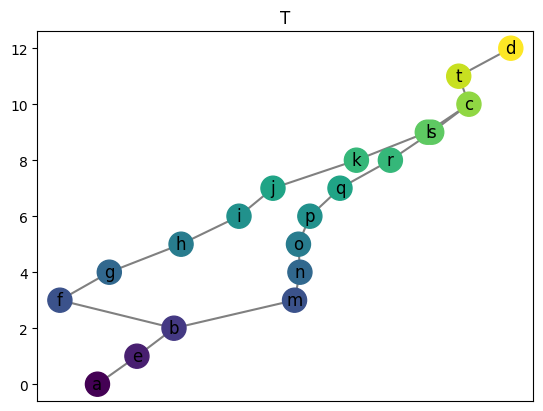

In [145]:
T = ex_mg.torus(0, 2, 10, 12, delta = 1, seed = 17)
T.draw()
plt.title('T')

Text(0.5, 1.0, 'L')

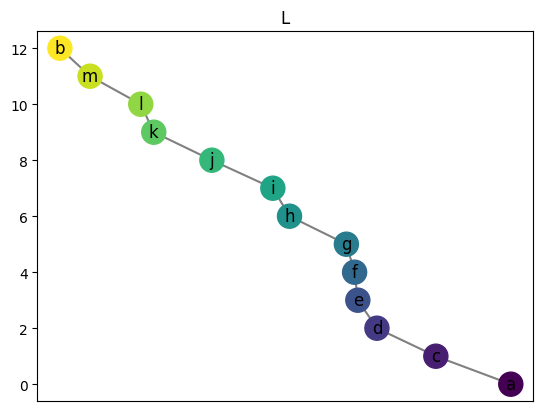

In [146]:
L = ex_mg.line(0, 12)
L.draw()
plt.title('L')

Create an interleaving and to generate all the relevant matrices.

Then, we can try to solve the problem using ILP.

In [147]:
myInt = Interleave(T, L, initialize_random_maps=True, seed=0)

## Let's get all the matrices. Diagram: Vertex triangle F_G_F.

Inclusion matrices to define the maps $F \to F_n \to F_{2n}$ and $G \to G_n \to G_{2n}$. Can be accessed by `Interleave.I`. 

For vertex triangle from $F$ to $G$, we need $I^V_{F^n}$ and $I^V_{F}$

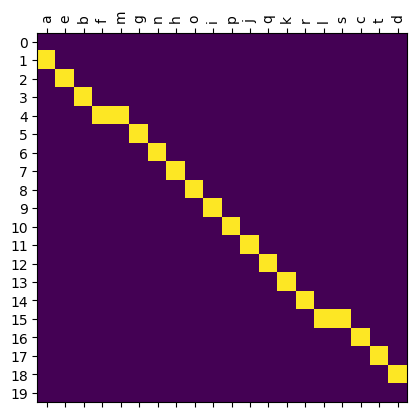

In [148]:
# Inclusion matrices 

I_F_0 = myInt.I('F', '0', 'V')
I_F_0.draw()

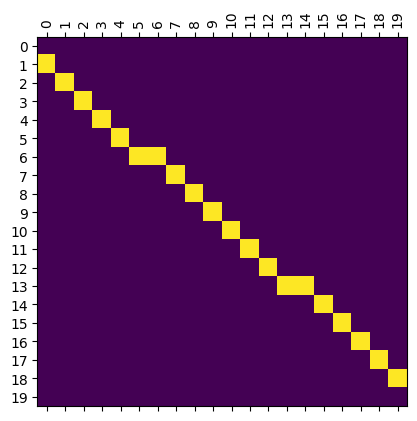

In [149]:
I_F_n = myInt.I('F', 'n', 'V')
I_F_n.draw()


Multiply $I^V_{F^n}$ with $I^V_{F}$ and denote it by $I$. <span style="color:red"> Is the multiplication method  correct? </span>

LabeledMatrix(
array=
[[1.]], 
rows=[15], 
cols=['c'])

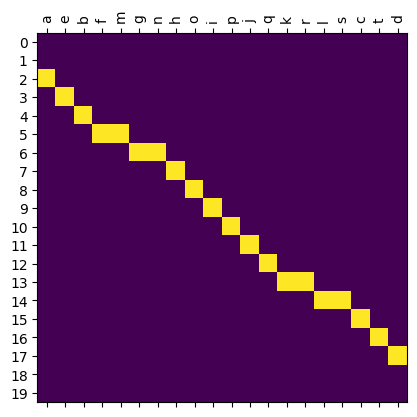

In [150]:
# multiply two matrices
I = I_F_n @ I_F_0
I.draw()

# Similar to inclusion matrices, we can index this matrix  by blocks.
I[10]

Store the distance matrix too. We need $D^V_{F^{2n}}$. Can be summoned by `Interleave.D`.

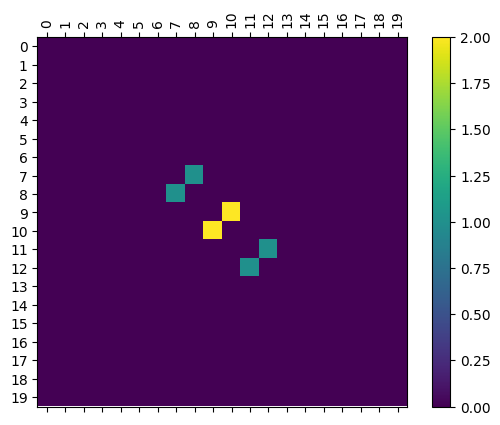

In [151]:
D = myInt.D('F', '2n', 'V')
D.draw(colorbar=True)

Let's also store a $\varphi_V$ and $\psi_V^n$ matrices. These two are variable matrices in the ILP. Can be summoned by `Interleave.phi` and `Interleave.psi`.

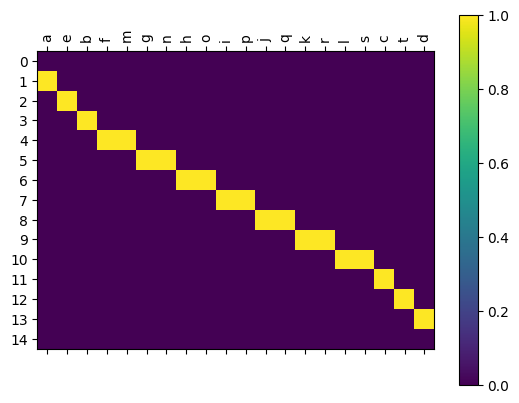

In [152]:
phi = myInt.phi('0', 'V')
phi.draw(colorbar=True)

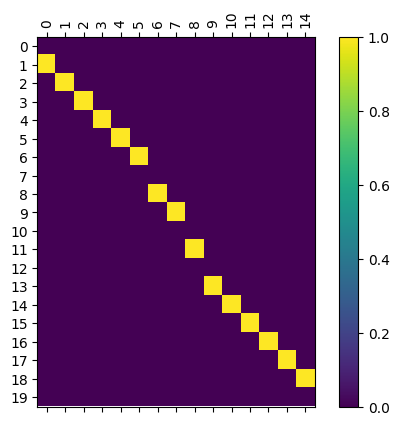

In [153]:
psi_n = myInt.psi('n', 'V')
psi_n.draw(colorbar=True)

## Attempt to set up the ILP.

### Initialize the ILP


In [154]:
prob = pulp.LpProblem("Triangle_ILP", pulp.LpMinimize)

### Matrix Parameters

In [155]:
I = I # Inclusion matrix
D = D # Distance matrix
phi = phi # Phi matrix
psi = psi_n # Psi matrix

<span style="color:red"> There should be a way to extract the dimensions from the matrices. Right now, I am hardcoding the dimensions. </span>

### Let's clear up the dimension problem


In [156]:
m = 20 # Number of rows in $\psi_n$
n = 15 # Number of columns in $\phi_n$ or Numbe of rows in $\phi$
p = 20 # Number of columns in $\phi$


<span style="color:red"> The block diagonal matrices cannot be unpacked. Right now, working with hardcoded matrices. </span>

In [157]:
# Distance matrix
D = np.zeros((m, p))
D[7,8] = 1
D[8,7] = 1
D[11,12] = 1
D[12,11] = 1
D[9,10] = 2
D[10,9] = 2


In [158]:
# Inclusion matrix

I = np.zeros((m, p))

### define the decision variables


In [159]:
z = pulp.LpVariable.dicts("z", ((i, j, k) for i in range(m) for j in range(n) for k in range(p)), cat='Binary')
psi_vars = pulp.LpVariable.dicts("psi", ((i, j) for i in range(m) for j in range(n)), lowBound=0, cat='Continuous')
phi_vars = pulp.LpVariable.dicts("phi", ((j, k) for j in range(n) for k in range(p)), lowBound=0, cat='Continuous')
psi_phi = pulp.LpVariable.dicts("psi_phi", ((i, k) for i in range(m) for k in range(p)), lowBound=0, cat='Continuous')
minmax_var = pulp.LpVariable("m", lowBound=0, cat='Continuous')

### Objective function

In [160]:
prob += minmax_var

### Constraints
1. $m \geq  \sum_{i=1}^{m} d_{ij}(I_{ik}-C_{ik})$ for each $j$ and $k$.
2. $-m \leq  \sum_{i=1}^{m} d_{ij}(I_{ik}-C_{ik})$ for each $j$ and $k$. 


In [161]:
for i in range(m):
    prob += minmax_var >= pulp.lpSum(D[i][j] *(I[i][k] - psi_phi[i][k]) for j in range(n) for k in range(p))
    prob += -minmax_var <= pulp.lpSum(D[i][j] *(I[i][k] - psi_phi[i][k]) for j in range(n) for k in range(p))

KeyError: 0

### Constraints

$C_{ik} = \sum_{j=1}^{n} z_{ijk}$ for each $i$ and $k$.

In [ ]:
for i in range(m):
    for k in range(p):
        prob += psi_phi[i][k] == pulp.lpSum(z[i, j, k] for j in range(n))


### Constraints

1. $z_{ijk} \leq \psi_{ij}$ for each $i$, $j$ and $k$.
2. $z_{ijk} \leq \phi_{jk}$ for each $i$, $j$ and $k$

In [ ]:
for i in range(m):
    for j in range(n):
        for k in range(p):
            prob += z[i, j, k] <= psi[i, j] 
            prob += z[i, j, k] <= phi[j, k]

### Constraints

$z_{ijk} \geq \psi_{ij} + \phi_{jk} - 1$ for each $i$, $j$ and $k$.

In [126]:
for i in range(m):
    for j in range(n):
        for k in range(p):
            prob += z[i, j, k] >= psi[i, j] + phi[j, k] - 1

KeyError: (0, 0)

### Constraints

1. $ \sum_{i=1}^{m} \psi_{ij} \leq 1$ for each $j$.
2. $ \sum_{j=1}^{m} \varphi{jk} \leq 1$ for each $k$.

In [125]:
for i in range(m):
    prob += pulp.lpSum(psi_vars[i,j] for j in range(n)) <= 1   

for j in range(n):
    prob += pulp.lpSum(phi_vars[j,k] for k in range(p)) <= 1

### Constraints

1. $ \psi_{ij} \geq 0$ for each $i$ and $j$.
2. $ \varphi_{jk} \geq 0$ for each $j$ and $k$.

In [127]:
for i in range(m):
    for j in range(n):
        prob += psi_vars[i,j] >= 0

for j in range(n):
    for k in range(p):
        prob += phi_vars[j,k] >= 0

## Solve the ILP

In [128]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ishikaghosh/anaconda3/envs/interleavingenv/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/f4150b565b8446df97d388e397f26919-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/f4150b565b8446df97d388e397f26919-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 640 COLUMNS
At line 1842 RHS
At line 2478 BOUNDS
At line 2479 ENDATA
Problem MODEL has 635 rows, 601 columns and 1200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-635) rows, 0 (-601) columns and 0 (-1200) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 0
After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 0 - 0 iterations time 0.002, Presolve 0.00
Opt

1

## Output the solution

In [141]:
print(f"Objective value (minimization over the maximum of the absolute values of the matrix) = {pulp.value(prob.objective)}")

Objective value (minimization over the maximum of the absolute values of the matrix) = 0.0
